In [5]:
import struct
from PIL import Image
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

In [6]:
file_list = [
    'ETL1C' + '\\ETL1C_01',
    'ETL1C' + '\\ETL1C_02',
    'ETL1C' + '\\ETL1C_03',
    'ETL1C' + '\\ETL1C_04',
    'ETL1C' + '\\ETL1C_05',
    'ETL1C' + '\\ETL1C_06',
    'ETL1C' + '\\ETL1C_07',
    'ETL1C' + '\\ETL1C_08',
    'ETL1C' + '\\ETL1C_09',
    'ETL1C' + '\\ETL1C_10',
    'ETL1C' + '\\ETL1C_11',
    'ETL1C' + '\\ETL1C_12',
    'ETL1C' + '\\ETL1C_13',
]

In [7]:
def read_record(f):
    s = f.read(2052)
    r = struct.unpack('>H2sH6BI4H4B4x2016s4x', s)
    img = Image.frombytes('F', (64, 63), r[18], 'bit', 4)
    il = img.convert('P')
    
    return r + (il,)

def read_kana():
    kana = np.zeros([51, 1411, 63, 64], dtype=np.uint8) # 51 characters, 1411 writers, img size = 63*64
    for idx in range(6,13):
        with open(file_list[idx], 'rb') as f:
            if idx != 12:
                limit = 8
            else:
                limit = 3
            
            for dataset in range(limit):
                for idx_writer in range(1411):
                    try:
                        r = read_record(f)
                        kana[(idx - 7) * 8 + dataset, idx_writer] = np.array(r[-1])
                    except struct.error:
                        pass
                    
    return kana

In [8]:
katakana = read_kana()

(63, 64, 3)

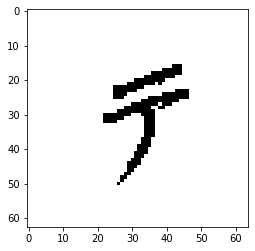

In [9]:
img = katakana[10][183]

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Black to white based on average color
avg_color_per_row = np.average(img, axis=0)
avg_color = np.average(avg_color_per_row, axis=0)

for idx1, first_iter in enumerate(img):
    for idx2, second_iter in enumerate(first_iter):
        for idx3, third_iter in enumerate(second_iter):
            if third_iter <= np.round(avg_color[idx3]):
                img[idx1][idx2][idx3] = 255
            elif third_iter <= np.round(avg_color[idx3]) + 1:
                img[idx1][idx2][idx3] = 255
            else:
                img[idx1][idx2][idx3] = 0
                
plt.imshow(img)
img.shape

In [10]:
mapping_label = [
    'ケ-ke',
    'コ-ko',
    'サ-sa',
    'シ-shi',
    'ス-su',
    'セ-se',
    'ソ-so',
    'タ-ta',
    'チ-chi',
    'ツ-tsu',
    'テ-te',
    'ト-to',
    'ナ-na',
    'ニ-ni',
    'ヌ-nu',
    'ネ-ne',
    'ノ-no',
    'ハ-ha',
    'ヒ-hi',
    'フ-fu',
    'ヘ-he',
    'ホ-ho',
    'マ-ma',
    'ミ-mi',
    'ム-mu',
    'メ-me',
    'モ-mo',
    'ヤ-ya',
    'イ-i',
    'ユ-yu',
    'エ-e',
    'ヨ-yo',
    'ラ-ra',
    'リ-ri',
    'ル-ru',
    'レ-re',
    'ロ-ro',
    'ワ-wa',
    'ヰ-wi', # index 38, (Exception it was wi)
    'ウ-u',
    'ヱ-we', # index 40, (Exception it was we)
    'ヲ-wo',
    'ン-n',
    'ア-a',
    'イ-i',
    'ウ-u',
    'エ-e',
    'オ-o',
    'カ-ka',
    'キ-ki',
    'ク-ku'
]

len(mapping_label)

51

In [11]:
def preprocess(img, threshold):
    for idx1, first in enumerate(img):
        for idx2, second in enumerate(first):
            if second < 5:
                img[idx1][idx2] = 255
            else:
                img[idx1][idx2] = (img[idx1][idx2] - 255) * -1

    img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    
    return img

def preprocess_white(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Black to white based on average color
    avg_color_per_row = np.average(img, axis=0)
    avg_color = np.average(avg_color_per_row, axis=0)

    for idx1, first_iter in enumerate(img):
        for idx2, second_iter in enumerate(first_iter):
            for idx3, third_iter in enumerate(second_iter):
                if third_iter <= np.round(avg_color[idx3]):
                    img[idx1][idx2][idx3] = 255
                elif third_iter <= np.round(avg_color[idx3]) + 1:
                    img[idx1][idx2][idx3] = 255
                else:
                    img[idx1][idx2][idx3] = 0
                    
    return img

In [12]:
# Save the Image
num_id = 0
save_dir = 'ETL1C\\IMG'

for idx1, kana in enumerate(katakana):
    if idx1 == 38 or idx1 == 40: continue
    else:
        for idx2, writer_img in enumerate(kana):
            filename = str(num_id) + "_" + mapping_label[idx1] + "_kana" + ".png"
            filename = os.path.join(save_dir, filename)
            cv2.imwrite(filename, preprocess_white(writer_img))
            num_id = num_id + 1